### Knowledge Graphs + Code + LLMs

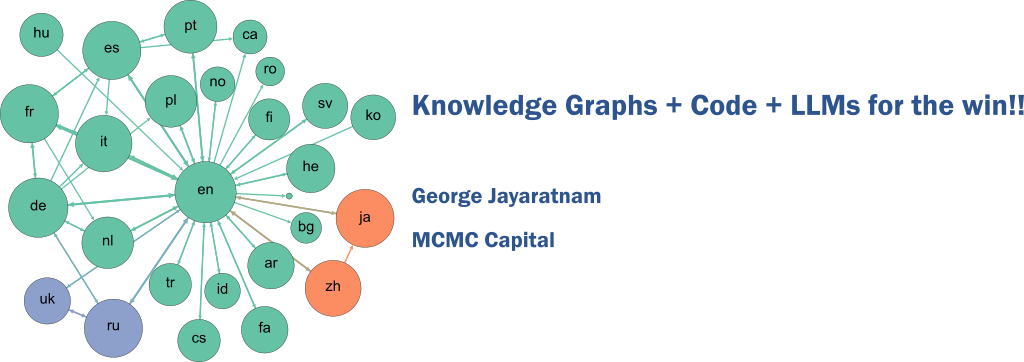

In [1]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/title.png"

# Display the PNG file
Image(filename=png_path)

### Summary

**The problem:** How to understand / piece together a large unfamiliar codebase when there is:
- Missing, scant, and sometimes inaccurate documentation
- Mixed use of technologies and frameworks + legacy code
- No easy way of tracking connected files, function, parameters, etc.
- No natural language explanation of code blocks  

**The solution:** This notebook shows how to use a knowledge graph to analyse connected data like a large codebase. The key features 
- Works primarily with metadata
- Ingest metadata into the graph quickly and start asking questions
- As more questions are triggered, the graph is progressively enhanced
- LLMs are used to help with an initial 'understanding' of what the code does
- Control over the input token limits of the LLM are managed via the graph queries 
- Although the demo is based on the teardown of a particular application (Zotero), the approach is generalisable to any codebase irrespective of size, language, tech stack, etc.

### Notebook summary: LLMs + Knowledge Graphs + Code

1. Knowledge graph (KG) basics
    - Basic concepts
    - Storage options


2. My use case: Improving Zotero's search capability
    - Hacking a complex codebase!
    - Knowledge graph design 


3. Part 1: A KG for the data layer
    - What are my questions
    - Buildling a knowledge graph on top of a RDBMS


4. Part 2: A KG for the application layer
    - Abstract Syntax Trees (AST)
    - Working with the Github Search API
    - LLMs to help with ***initial*** code explanations


5. Part 3: A KG for the business domain layer
    - GraphRAG for text
    - Public ontologies

   
6. Key takeways + Resources

### The big picture

###### Diagram: What I'm trying to build

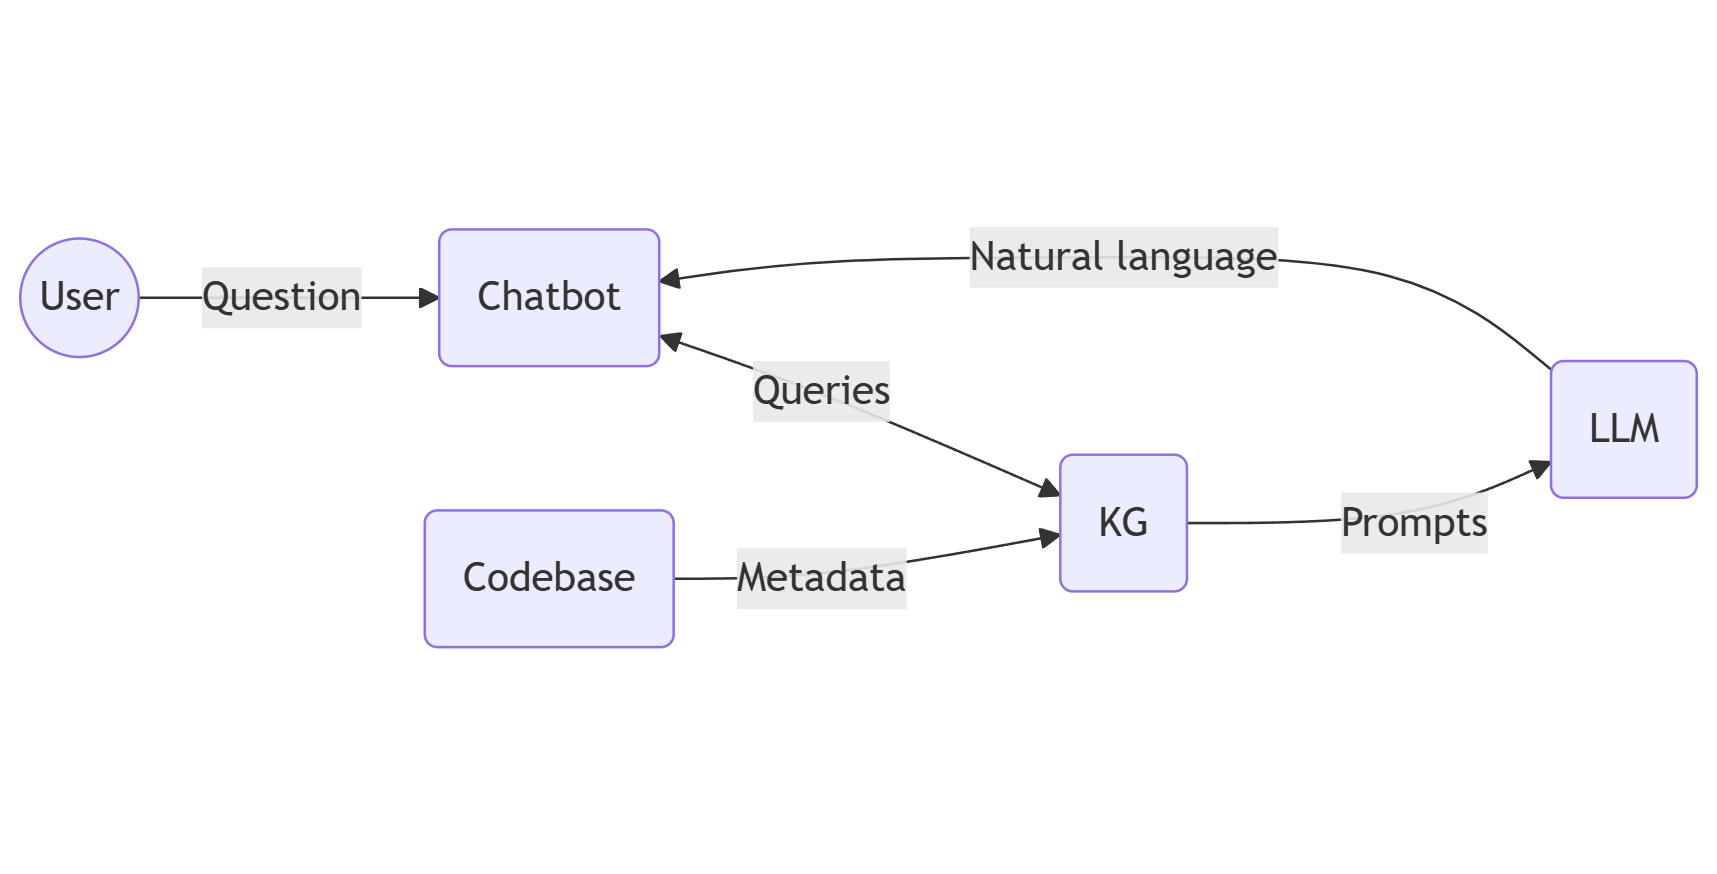

In [4]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/bigPicture.png"

# Display the PNG file
Image(filename=png_path)

This knowledge graph demo is designed to be a federation of 3 separate knowledge graphs - the Data KG (Part 1), the Application KG (Part 2), and the Business KG (Part 3).

Each KG ingests metadata from different sources and caters to questions about their respective layer. 

###### Diagram: Structured data - creating the Data and Application KGs

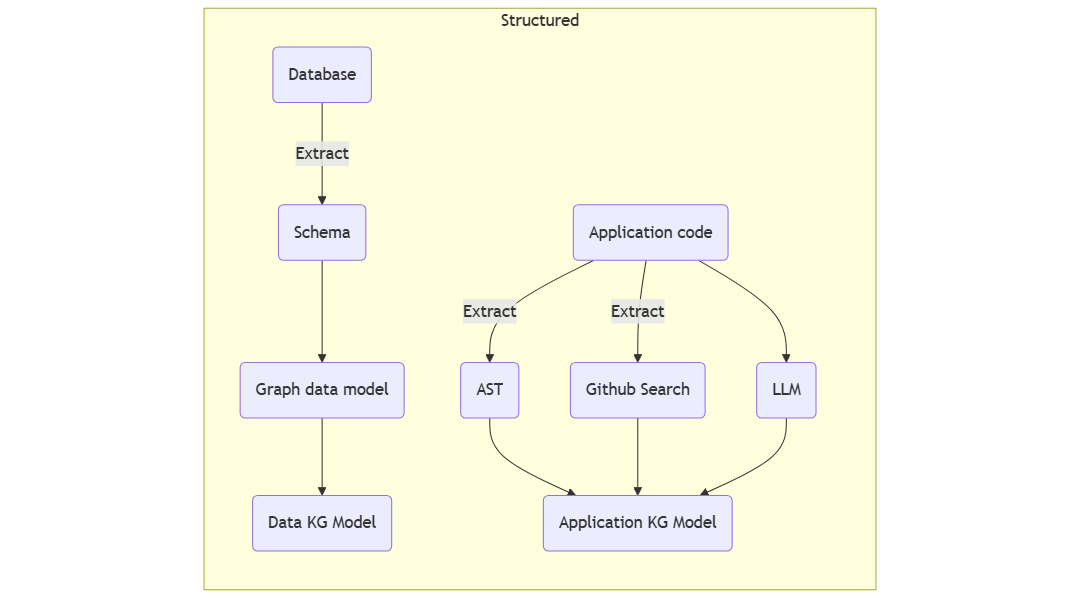

In [5]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/structuredOverview.png"

# Display the PNG file
Image(filename=png_path)

###### Diagram: Unstructured data - creating the Business Domain KGs

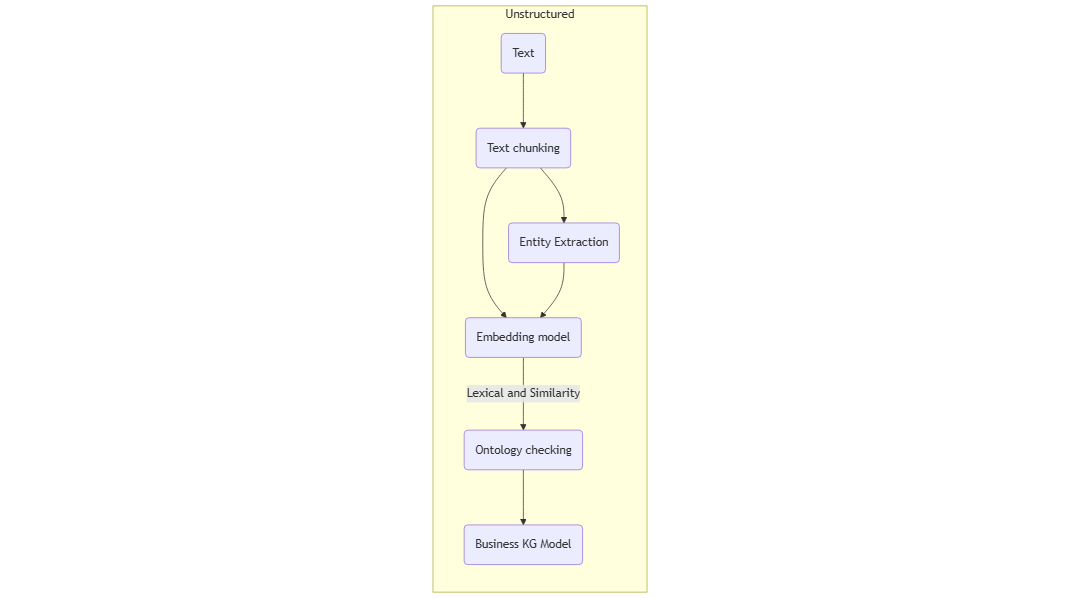

In [6]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/unstructuredOverview.png"

# Display the PNG file
Image(filename=png_path)

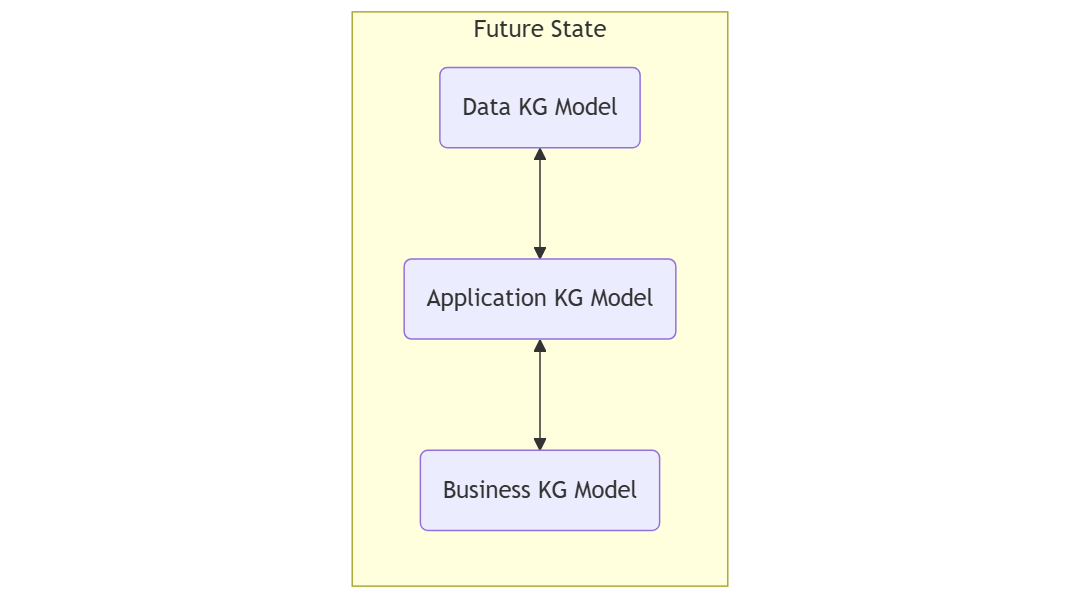

In [8]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/combined.png"

# Display the PNG file
Image(filename=png_path)

*Diagrams inspired by the work of [Paco Nathan](https://www.youtube.com/watch?v=B6_NfvQL-BE), a KG industry guru*

### 1. Knowledge graph (KG) 

###### What are knowledge graphs?

> "Knowledge graphs are a way of organizing and representing information in a machine-readable format. A knowledge graph represents a collection of real-world concepts (displayed as nodes) and relationships (displayed as edges) in the form of a graph used to link and integrate data coming from diverse sources."
> 
> `-` [data.world](https://data.world/blog/what-is-a-knowledge-graph/)


*My take* - Just a way of representing knowledge to:


1. Answer questions - context


2. Able to be read by machines/code


3. Is accurate - traceability


4. Easily updatable - new learning/refactor

###### Storage options

Many ways to store a knowledge graph:


1. Graph databases

   1. Neo4j
         
   2. Janus (open source)

   3. TigerGraph

    
2. RDF triplestores

   1. Blazegraph (Wikipedia)
   
   2. GraphDB (Ontotext)
     
   3. PoolParty


3. Elasticsearch - requires plugins


4. RDBMS - MySQL at Facebook (2004)  

###### Neo4j example 

- Graph example from Neo4j


- Data from the 
[StackOverflow Questions API](https://neo4j.com/graphgists/1a1d669d-8f35-485c-afe7-b4e0bf45d7d7/)


- Ingested into a Neo4j graph model

###### Neo4J - Why I ended up choosing them

- Build my own PageRank for contextual text search


- Started with Elasticsearch


- Neo4j easiest to get onboarded


- Free local and cloud options


- Query syntax (Cypher) similar to SQL


- Cypher moving to W3C standard - can work with other compliant graph DBs 
(SAP HANA 
Graph)

###### Neo4j example 

- Graph example from Neo4j


- Data from the 
[StackOverflow Questions API](https://neo4j.com/graphgists/1a1d669d-8f35-485c-afe7-b4e0bf45d7d7/)


- Ingested into a Neo4j graph model

###### Code: Setup environment and cypher query function

In [1]:
# Setup env and key query function
from dotenv import load_dotenv
from neo4j import GraphDatabase
from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
import os
import pandas as pd
import requests
import time
import base64
import subprocess
import json
import pickle
import datetime
import pytz
import re
import ast
from langchain_openai import ChatOpenAI
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_core.prompts.prompt import PromptTemplate
from langchain.schema import AIMessage
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate

load_dotenv()

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
UN = os.getenv("NEO4J_USERNAME")
PW = os.getenv("NEO4J_PASSWORD")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")


# Define a function to run a Cypher query   
def run_cypher_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters)
        # Fetch and return the results
        return result.data()

###### Code: Stackoverflow graph schema: View, Nodes, Counts

In [2]:
# Generic function to run Cypher queries
with GraphDatabase.driver("bolt://localhost:7687", auth=AUTH, database='stackoverflow') as driver:
    driver.verify_connectivity()
    print("Connection established.")

    # Generate graph from Cypher query
    g = Neo4jGraphWidget(driver)
    # View schema
    g.show_cypher("CALL db.schema.visualization()")

    # Query to list all nodes and their properties
    query_stack_nodes = """
    CALL db.schema.nodeTypeProperties() 
    YIELD nodeType, propertyName 
    RETURN nodeType AS label, COLLECT(propertyName) AS properties
    """
    result_query_stack_nodes = run_cypher_query(query_stack_nodes)
    df_result_query_stack_nodes = pd.DataFrame(result_query_stack_nodes)
    print(f"Results: query_stack_nodes\n{df_result_query_stack_nodes}\n")

    # Query to print a sample of 5 records from the Tag node
    query_tag_sample = """
    MATCH (t:Tag)  
    RETURN t AS tag_props 
    LIMIT 5;
    """
    result_query_tag_sample = run_cypher_query(query_tag_sample)
    df_result_query_tag_sample = pd.DataFrame(result_query_tag_sample)
    print(f"Results: query_tag_sample\n{df_result_query_tag_sample}\n")

    # Query to count the frequency of nodes
    query_stack = """
    MATCH (n)
    RETURN labels(n) AS label, count(*) AS count
    ORDER BY count DESC;
    """

    result_stack = run_cypher_query(query_stack)
    df_stack_nodes = pd.DataFrame(result_stack)
    # Flatten the 'label' column since it's a list
    df_stack_nodes['label'] = df_stack_nodes['label'].apply(lambda x: x[0] if len(x) > 0 else None)
    print(f"Results: df_stack_nodes['label']\n{df_stack_nodes}\n")  # Outputs the list of nodes (Persons)

# Close the driver
driver.close()

Connection established.


GraphWidget(layout=Layout(height='500px', width='100%'))

Results: query_stack_nodes
         label                                         properties
0      :`User`                               [uuid, display_name]
1       :`Tag`                                       [name, link]
2    :`Answer`  [uuid, title, link, is_accepted, body_markdown...
3   :`Comment`                                [uuid, link, score]
4  :`Question`  [uuid, title, creation_date, accepted_answer_i...

Results: query_tag_sample
                                           tag_props
0  {'name': 'neo4j', 'link': 'https://stackoverfl...
1  {'name': 'subgraph', 'link': 'https://stackove...
2  {'name': 'graph', 'link': 'https://stackoverfl...
3  {'name': 'cypher', 'link': 'https://stackoverf...
4  {'name': 'graph-databases', 'link': 'https://s...

Results: df_stack_nodes['label']
      label  count
0  Question   1589
1   Comment   1396
2    Answer   1367
3      User   1365
4       Tag    476



###### Diagram: Stackoverflow schema - from code result

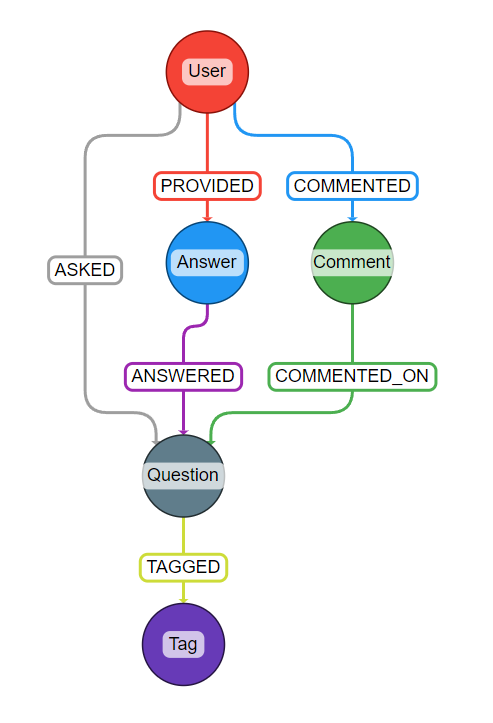

In [6]:
from IPython.display import Image

# Specify the path to your PNG file
png_path = r"Diagrams/PNG/stackoverflow_schema.png"

# Display the PNG file
Image(filename=png_path)

So what types of questions can we answer from this schema?


**Question: "How are tags related to other tags?"**


```
    MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
    WHERE t1.name < t2.name AND t1.name <> 'neo4j' AND t2.name <> 'neo4j'
    RETURN t1.name AS TAG_1, t2.name AS TAG_2 , count(*) AS freq
    ORDER BY freq DESC LIMIT 10;
```


* Each tag is a unique instance of the `Tag` node 


Answer **requires multiple joins** via the Question Node.

###### Code: Query to calculate the frequency of the top 10 tag-pairs

In [7]:
# import pandas as pd
# from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget

with GraphDatabase.driver(URI, auth=AUTH, database='stackoverflow') as driver:
    driver.verify_connectivity()
    print("Neo4j connection established.")

    # Question: "How are tags related to other tags"
    query_tags = """
    MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
    WHERE t1.name < t2.name AND t1.name <> 'neo4j' AND t2.name <> 'neo4j'
    RETURN t1.name AS TAG_1, t2.name AS TAG_2 , count(*) AS freq
    ORDER BY freq DESC LIMIT 10;
    """

    result_tags = run_cypher_query(query_tags)
    df_result_tags = pd.DataFrame(result_tags)
    # Flatten the 'label' column since it's a list
    # df_result_4['label'] = df_result_4['label'].apply(lambda x: x[0])
    print(f"Tag-pair frequency\n{df_result_tags}\n")  # Outputs the list of tag-pair frequencies

driver.close()

Neo4j connection established.
Tag-pair frequency
    TAG_1            TAG_2  freq
0  cypher       neo4j-apoc    86
1  cypher  graph-databases    79
2  cypher            graph    46
3  cypher           python    32
4  cypher         database    30
5  cypher             java    29
6  cypher       redisgraph    27
7  py2neo           python    20
8  cypher          graphql    17
9    java           spring    17



###### Key points: Representing knowledge in a graph database

1. Both nodes and relationships can have multiple properties - numbers, text,
 dates


2. Two nodes can have multiple relationships between them


3. Graph databases have a schema but they are flexible / easy to refactor


4. Graph schema design depends on the types of questions you want to ask 


5. Suited for questions/queries where the intermediate nodes are not known - 
multi-hop


6. Pre-processing data prior to ingestion may require some effort